<a href="https://www.kaggle.com/code/ayushkumarnayak/store-sales-prediction-with-arima-models?scriptVersionId=171024083" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.express as px

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
oil=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holidays_events=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
sample_submission=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
stores=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
test=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
train=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [4]:
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [5]:
test.tail()

id        date  store_nbr                      family  onpromotion
28507  3029395  2017-08-31          9                     POULTRY            1
28508  3029396  2017-08-31          9              PREPARED FOODS            0
28509  3029397  2017-08-31          9                     PRODUCE            1
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399  2017-08-31          9                     SEAFOOD            0

In [6]:
oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [7]:
transactions.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [8]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [9]:
holidays_events.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

# **Merging datasets**

In [10]:
train=train.merge(stores,on='store_nbr')
train=train.merge(oil,on='date',how='left')
holidays_events= holidays_events.rename(columns={'type': 'holiday_type'})
train= train.merge(holidays_events, on='date', how='left')
train.head()

id        date  store_nbr      family  sales  onpromotion   city  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito   
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito   
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito   
4   4  2013-01-01          1       BOOKS    0.0            0  Quito   

       state type  cluster  dcoilwtico holiday_type    locale locale_name  \
0  Pichincha    D       13         NaN      Holiday  National     Ecuador   
1  Pichincha    D       13         NaN      Holiday  National     Ecuador   
2  Pichincha    D       13         NaN      Holiday  National     Ecuador   
3  Pichincha    D       13         NaN      Holiday  National     Ecuador   
4  Pichincha    D       13         NaN      Holiday  National     Ecuador   

          description transferred  
0  Primer dia del ano       False  
1  Primer dia del ano       False  
2  Primer dia del ano       False  
3  Primer dia del ano       False  
4  Primer dia del ano       False

In [11]:
train.describe()

id     store_nbr         sales   onpromotion       cluster  \
count  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06   
mean   1.504277e+06  2.750000e+01  3.590209e+02  2.617480e+00  8.481481e+00   
std    8.662610e+05  1.558579e+01  1.107286e+03  1.225494e+01  4.649735e+00   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    7.546768e+05  1.400000e+01  0.000000e+00  0.000000e+00  4.000000e+00   
50%    1.507572e+06  2.750000e+01  1.100000e+01  0.000000e+00  8.500000e+00   
75%    2.255120e+06  4.100000e+01  1.960110e+02  0.000000e+00  1.300000e+01   
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02  1.700000e+01   

         dcoilwtico  
count  2.099196e+06  
mean   6.801587e+01  
std    2.569134e+01  
min    2.619000e+01  
25%    4.641000e+01  
50%    5.343000e+01  
75%    9.581000e+01  
max    1.106200e+02

# **Handling Missing Values**

In [12]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [13]:
missing = train.isnull().sum()/ len(train) * 100 
print(missing)

id               0.000000
date             0.000000
store_nbr        0.000000
family           0.000000
sales            0.000000
onpromotion      0.000000
city             0.000000
state            0.000000
type             0.000000
cluster          0.000000
dcoilwtico      31.271879
holiday_type    83.547258
locale          83.547258
locale_name     83.547258
description     83.547258
transferred     83.547258
dtype: float64


In [14]:
remove = missing[missing > 30].index
train= train.drop(columns=remove)
train= train.drop_duplicates()
train

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3054343  3000883  2017-08-15          9                     POULTRY   438.133   
3054344  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3054345  3000885  2017-08-15          9                     PRODUCE  2419.729   
3054346  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3054347  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type  cluster  
0                  0  Quito  Pichincha    D       13  
1                  0  Quito  Pichincha    D       13  
2                  0  Quito  Pichincha    D       13  
3                  0  Quito  Pichincha    D       13  
4                  0  Quito  Pichincha    D       13  
...              ...    ...        ...  ...      ...  
3054343            0  Quito  Pichincha    B        6  
3054344            1  Quito  Pichincha    B        6  
3054345          148  Quito  Pichincha    B        6  
3054346            8  Quito  Pichincha    B        6  
3054347            0  Quito  Pichincha    B        6  

[3000888 rows x 10 columns]

In [15]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64

# **Exploratory Data Analysis**

# Questions to understand the dataset

 1. Which stores have the highest and the lowest sales?
 2. Top 10 families with the highest sales?
 3. Which time of the year do we the see the most and the least sales?
 4. How are the sales affected by promotions?
 5. How does type of store affect the store sales?
 6. Which cities and states have the most and least customers?
 7. Which type of stores attract the most and least customers?

**1. Which stores have the highest and lowest sales**

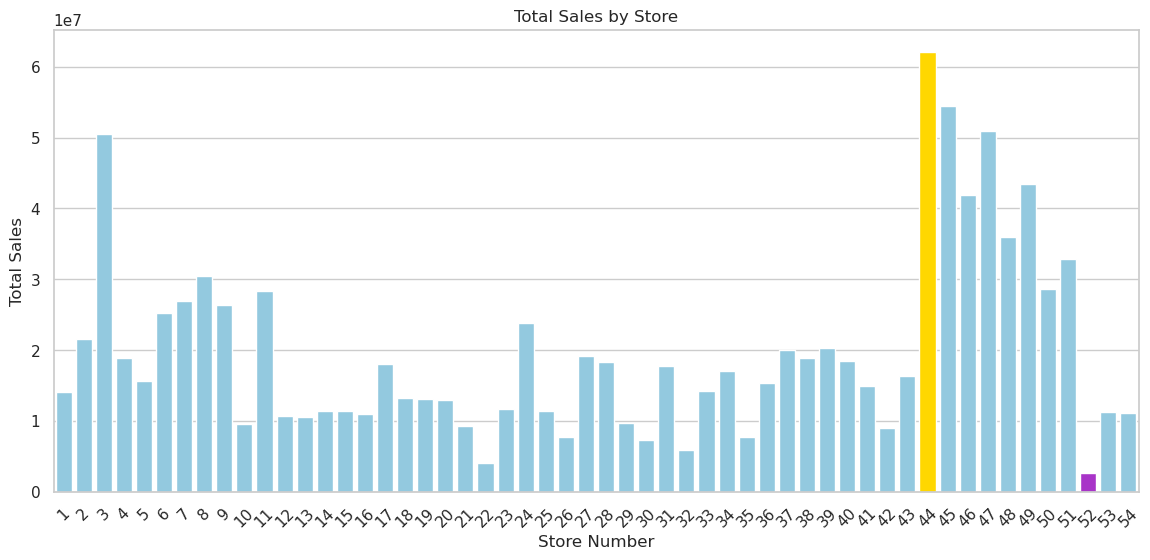

In [16]:
store_sales = train.groupby('store_nbr')['sales'].sum().reset_index() 
store_sales = store_sales.sort_values('sales', ascending=False)
sns.set(style="whitegrid", color_codes=True)

# Creating a bar plot

plt.figure(figsize=(14, 6))
bar=sns.barplot(data=store_sales, x='store_nbr', y='sales',color='skyblue')
patch_h = [patch.get_height() for patch in bar.patches] 

# patch_h contains the heights of all the patches now

idx_tallest = np.argmax(patch_h) 
idx_smallest= np.argmin(patch_h)

# np.argmax return the index of largest value of the list and np.argmin returns the index of the smallest value

bar.patches[idx_tallest].set_facecolor('gold') 
bar.patches[idx_smallest].set_facecolor('#a834c8') 
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store')
plt.xticks(rotation=45)
plt.show()

**2. Top 10 families with the highest sales?**

In [17]:
#Creating a Pie chart #plotly
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False)
top_10=family_sales.head(10)
fig = px.pie(values=top_10, names=top_10.index, color=top_10.index, color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.show()

**3. Which time of the year do we see the most and the least sales?**

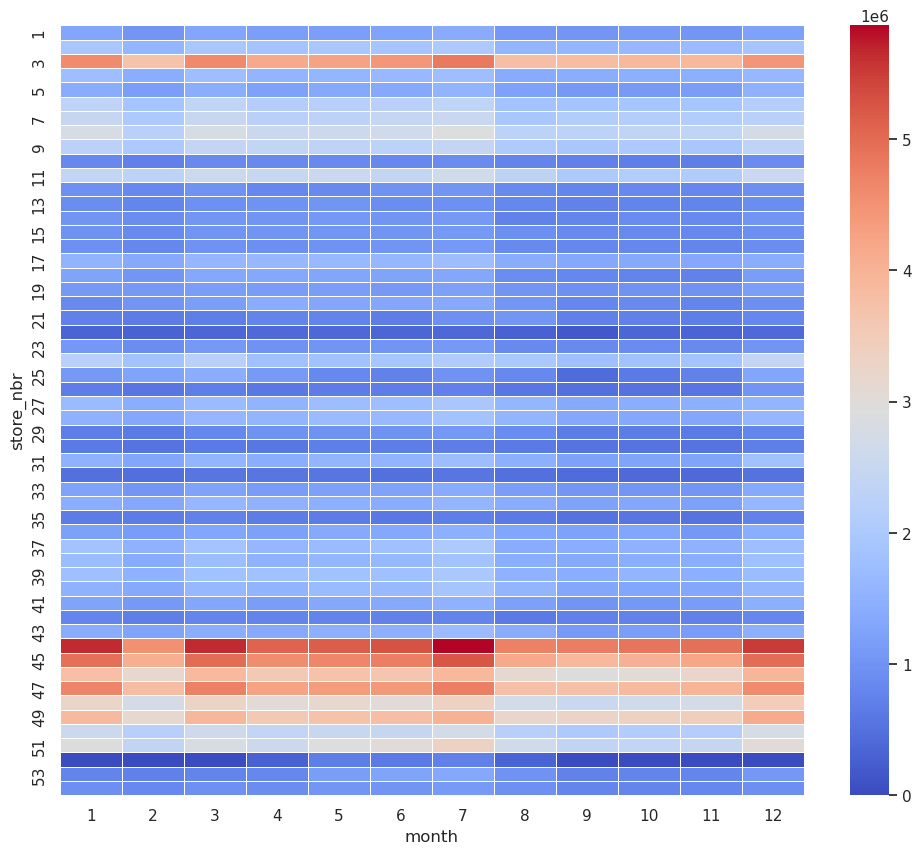

In [18]:
plt.figure(figsize=(12,10))
train['date']= pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_name'] = pd.to_datetime(train['date']).dt.day_name()
table = pd.pivot_table(train, values ='sales', index =['store_nbr'],columns =['month'], aggfunc = np.sum)     
sns.heatmap(table, annot=False, linewidths=.5, cmap="coolwarm")
plt.show()

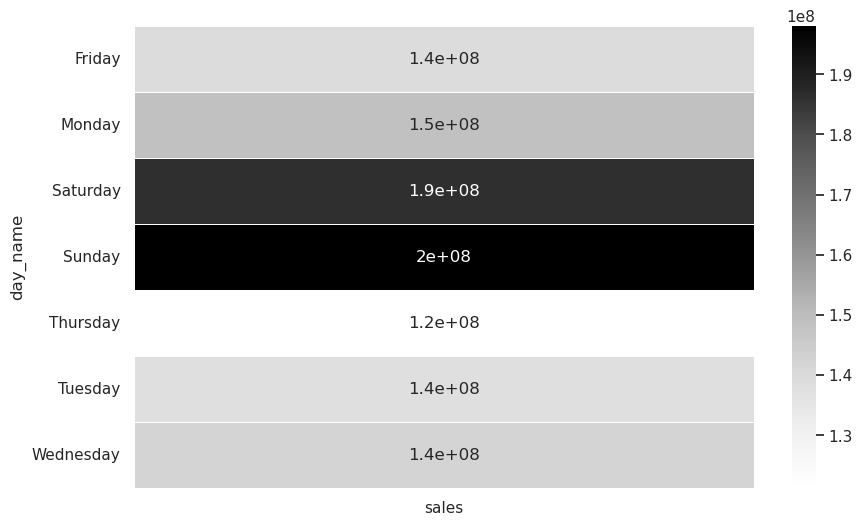

In [19]:
table1 = pd.pivot_table(train, values ='sales', index =['day_name'], aggfunc = np.sum)
fig, ax = plt.subplots(figsize=(10,6))         
sns.heatmap(table1, annot=True, linewidths=.5, ax=ax, cmap="Greys")
plt.show()

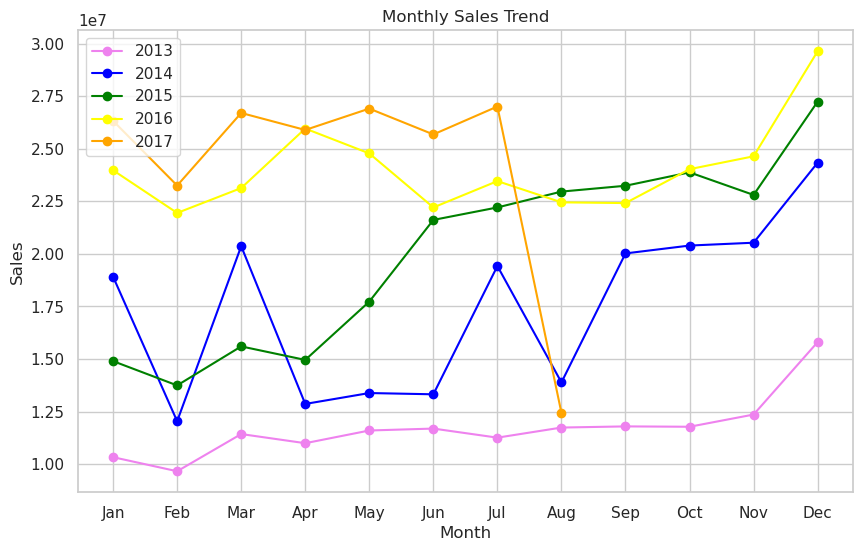

In [20]:
plt.figure(figsize=(10, 6))  #plotly
monthly_sales = train.groupby(['month', 'year'])['sales'].sum().reset_index()
years = monthly_sales['year'].unique()
colors = itertools.cycle(['violet', 'blue', 'green', 'yellow', 'orange'])

for year in years:
    year_data = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_data['month'], year_data['sales'], marker='o', color=next(colors), label=str(year))

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)
plt.legend()
plt.show()

In [21]:
fig=px.scatter(train[train.store_nbr==1], x="onpromotion", y="sales")
fig.show()

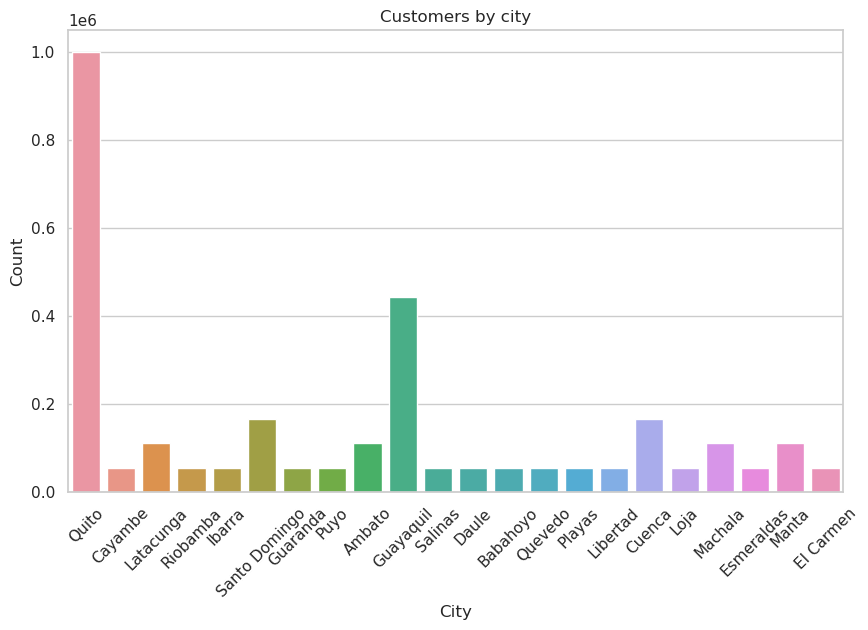

In [22]:
plt.figure(figsize=(10, 6))  
sns.countplot(data=train, x='city')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Customers by city')
plt.xticks(rotation=45)
plt.show()

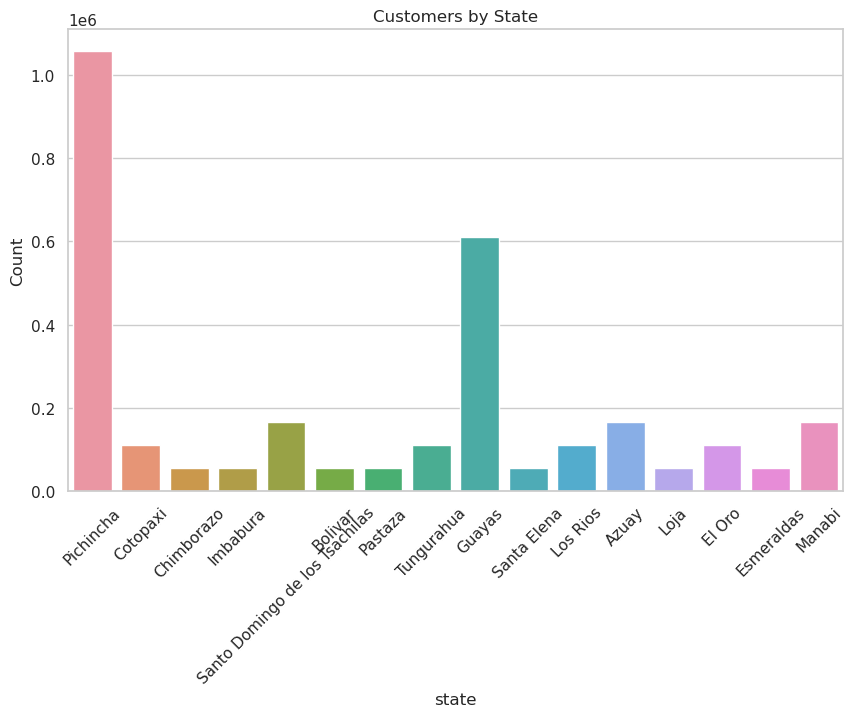

In [23]:
plt.figure(figsize=(10, 6))  
sns.countplot(data=train, x='state')
plt.xlabel('state')
plt.ylabel('Count')
plt.title('Customers by State')
plt.xticks(rotation=45)
plt.show()

# **Handling outliers**

In [24]:
fig = px.scatter(train[train.store_nbr==1], x="date", y="sales")
fig.show()

In [25]:
for i in range(1,len(train.store_nbr.unique())+1):
    val = train[train.store_nbr == i].sales.quantile(0.99)
    train = train.drop(train[(train.store_nbr==i) & (train.sales > val)].index)
fig = px.scatter(train[train.store_nbr==4], x="date", y="sales")
fig.show()

In [26]:
train = train.groupby('date')['sales','onpromotion'].sum().reset_index()
train.set_index('date',inplace=True)
train.index = pd.to_datetime(train.index)
print(pd.date_range(start="2013-01-01", end="2017-08-15").difference(train.index))

/tmp/ipykernel_20/3497754776.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [27]:
idx = pd.date_range(start="2013-01-01", end="2017-08-15",freq='D')
train= train.reindex(idx, fill_value=train['sales'].mean())
train.at['2013-01-01','sales']=train['sales'].mean()
train.at['2014-01-01','sales']=train['sales'].mean()
train.at['2015-01-01','sales']=train['sales'].mean()
train.at['2016-01-01','sales']=train['sales'].mean()
train.at['2017-01-01','sales']=train['sales'].mean()

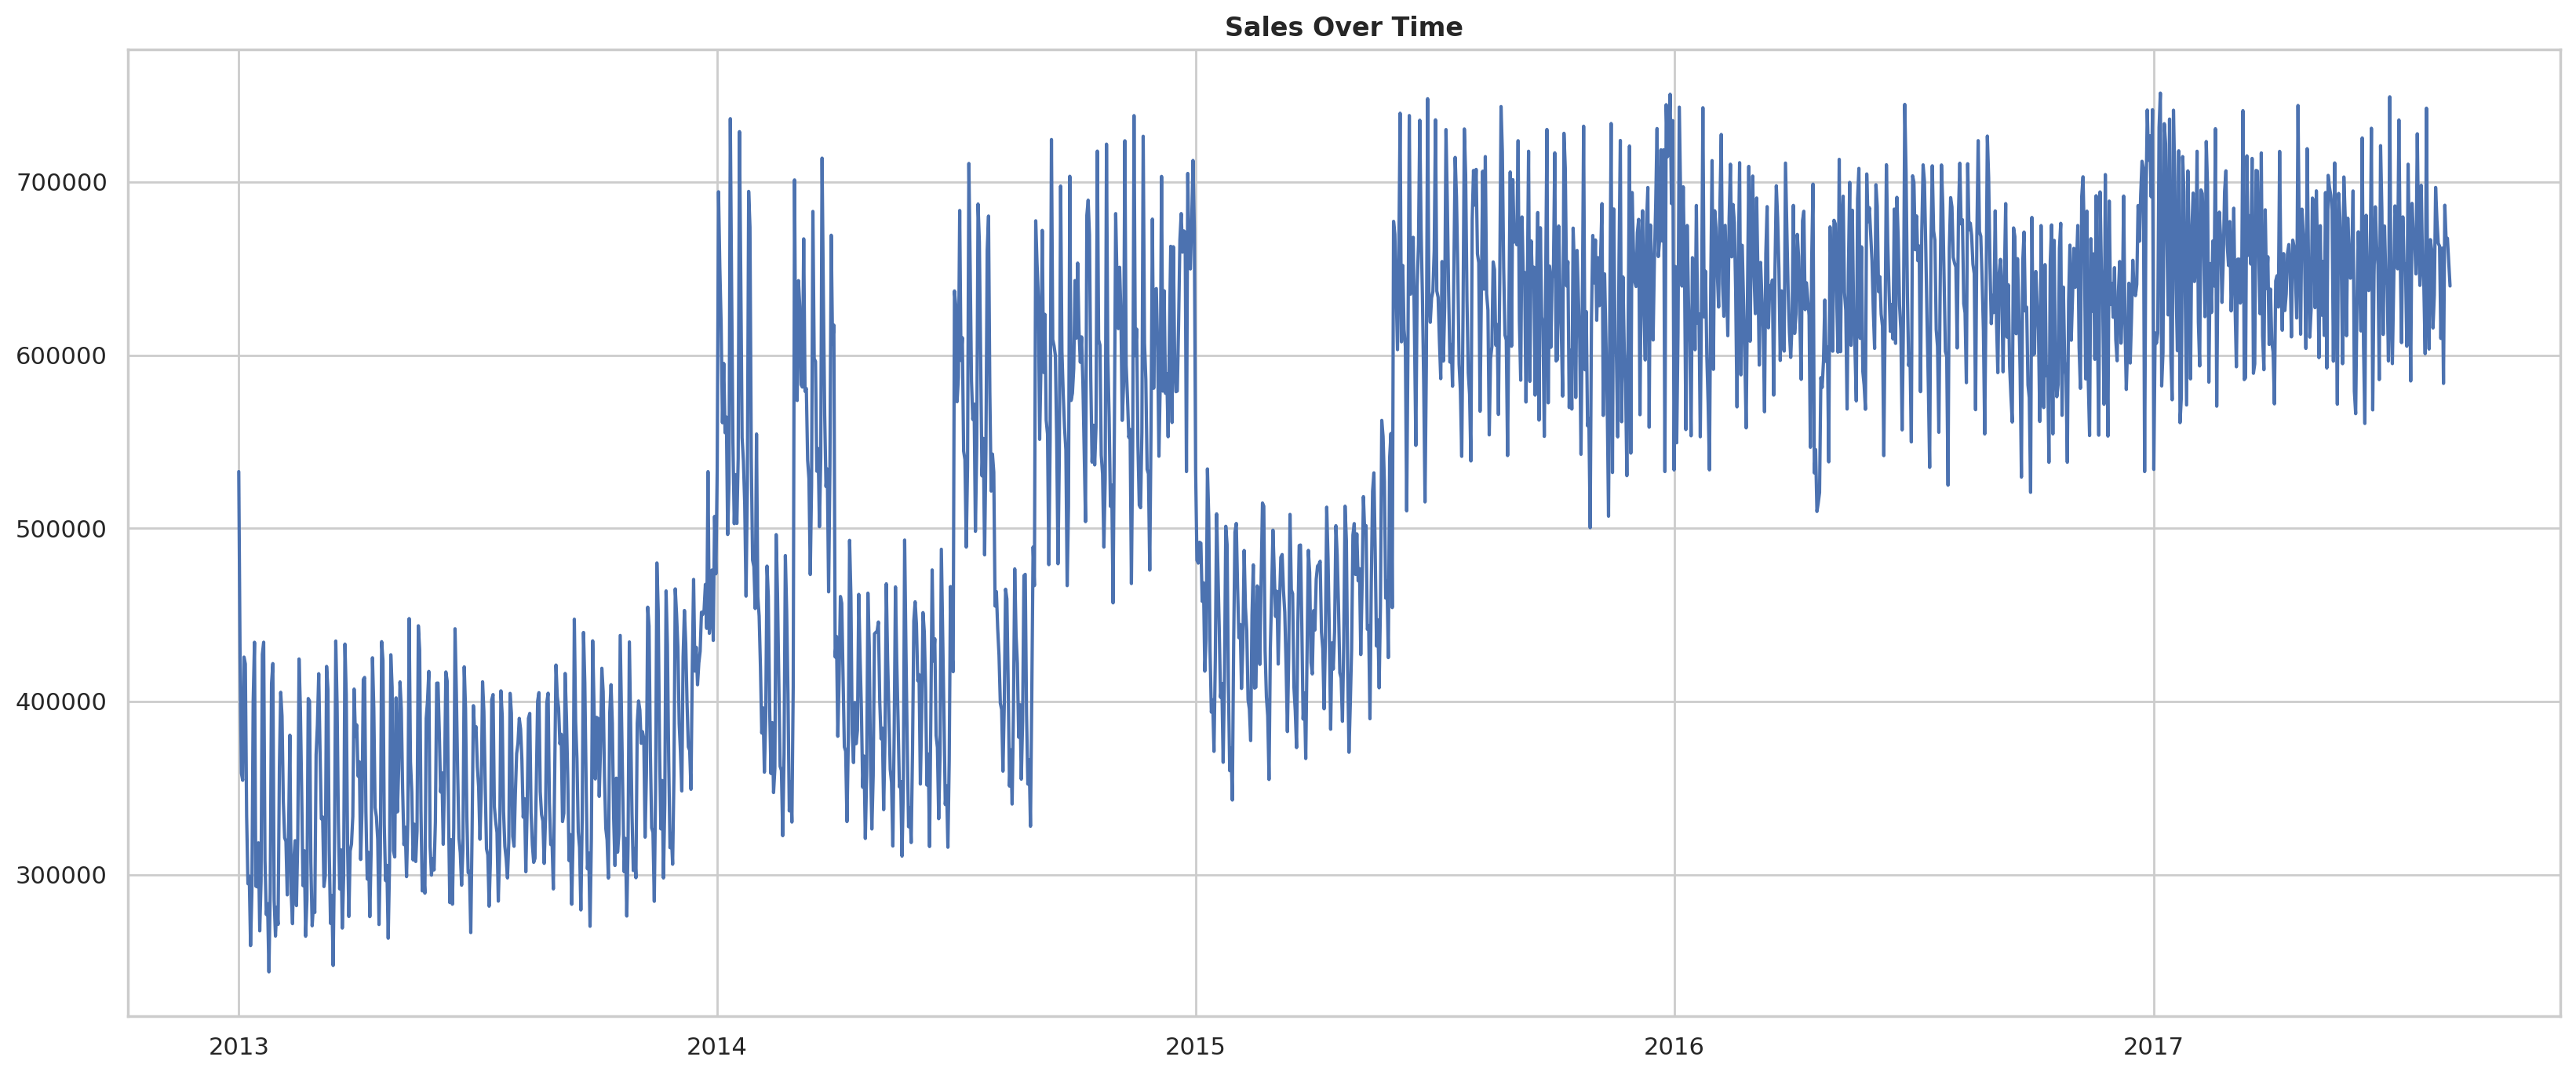

In [28]:
plt.figure(figsize=(20,8), dpi=200)
plt.plot(train.index,train.sales)
plt.title('Sales Over Time', fontweight='bold', fontsize=12);

In [29]:
train2=train.drop(columns='onpromotion')

# **Decomposition of Time series**

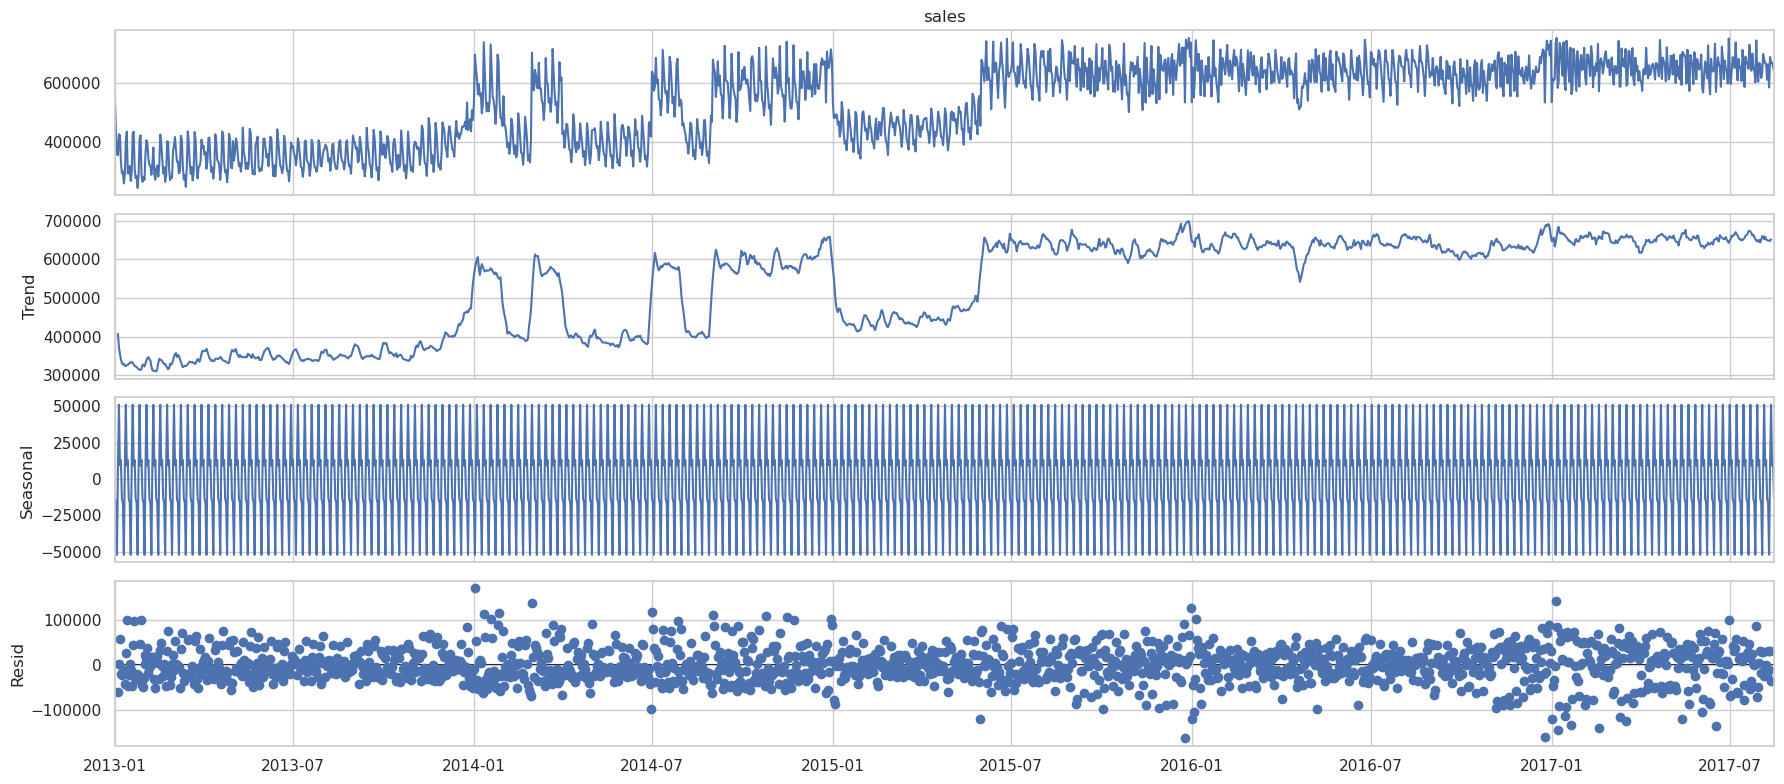

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from statsmodels.tsa.seasonal import seasonal_decompose
# Additive Decomposition
add_decomp = seasonal_decompose(train2.sales, model='additive')
fig = add_decomp.plot();

# **Differencing**

In [31]:
train_diff = train2.diff().dropna()
train_diff.head()

sales
2013-01-02 -107652.576919
2013-01-03  -66463.186820
2013-01-04   -4144.554031
2013-01-05   71143.444136
2013-01-06   -3903.720141

In [32]:
from termcolor import colored
# Current time series tested for stationarity
adfuller_result = adfuller(train2.sales)
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
if adfuller_result[1] < 0.05:
    print(colored("\nThe time series is stationary",'green',attrs=['bold']))
else:
    print(colored("\nThe time series is not stationary",'red',attrs=['bold']))
for key, value in adfuller_result[4].items():
    print('\nCritial Values:')
    print(f' {key}, {value}')

ADF Statistic: -2.6219457719585613
p-value: 0.08854581692625624

The time series is not stationary

Critial Values:
 1%, -3.4342859473725906

Critial Values:
 5%, -2.8632784969542016

Critial Values:
 10%, -2.56769553371452


In [33]:
adfuller_result = adfuller(train_diff.sales)
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p-value: {adfuller_result[1]}')
if adfuller_result[1] < 0.05:
    print(colored("\nThe time series is stationary",'green',attrs=['bold']))
else:
    print(colored("\nThe time series is not stationary",'red',attrs=['bold']))
for key, value in adfuller_result[4].items():
    print('\nCritial Values:')
    print(f' {key}, {value}')

ADF Statistic: -9.45306858087018
p-value: 4.56116808794479e-16

The time series is stationary

Critial Values:
 1%, -3.4342930672797065

Critial Values:
 5%, -2.8632816397229064

Critial Values:
 10%, -2.567697207194407


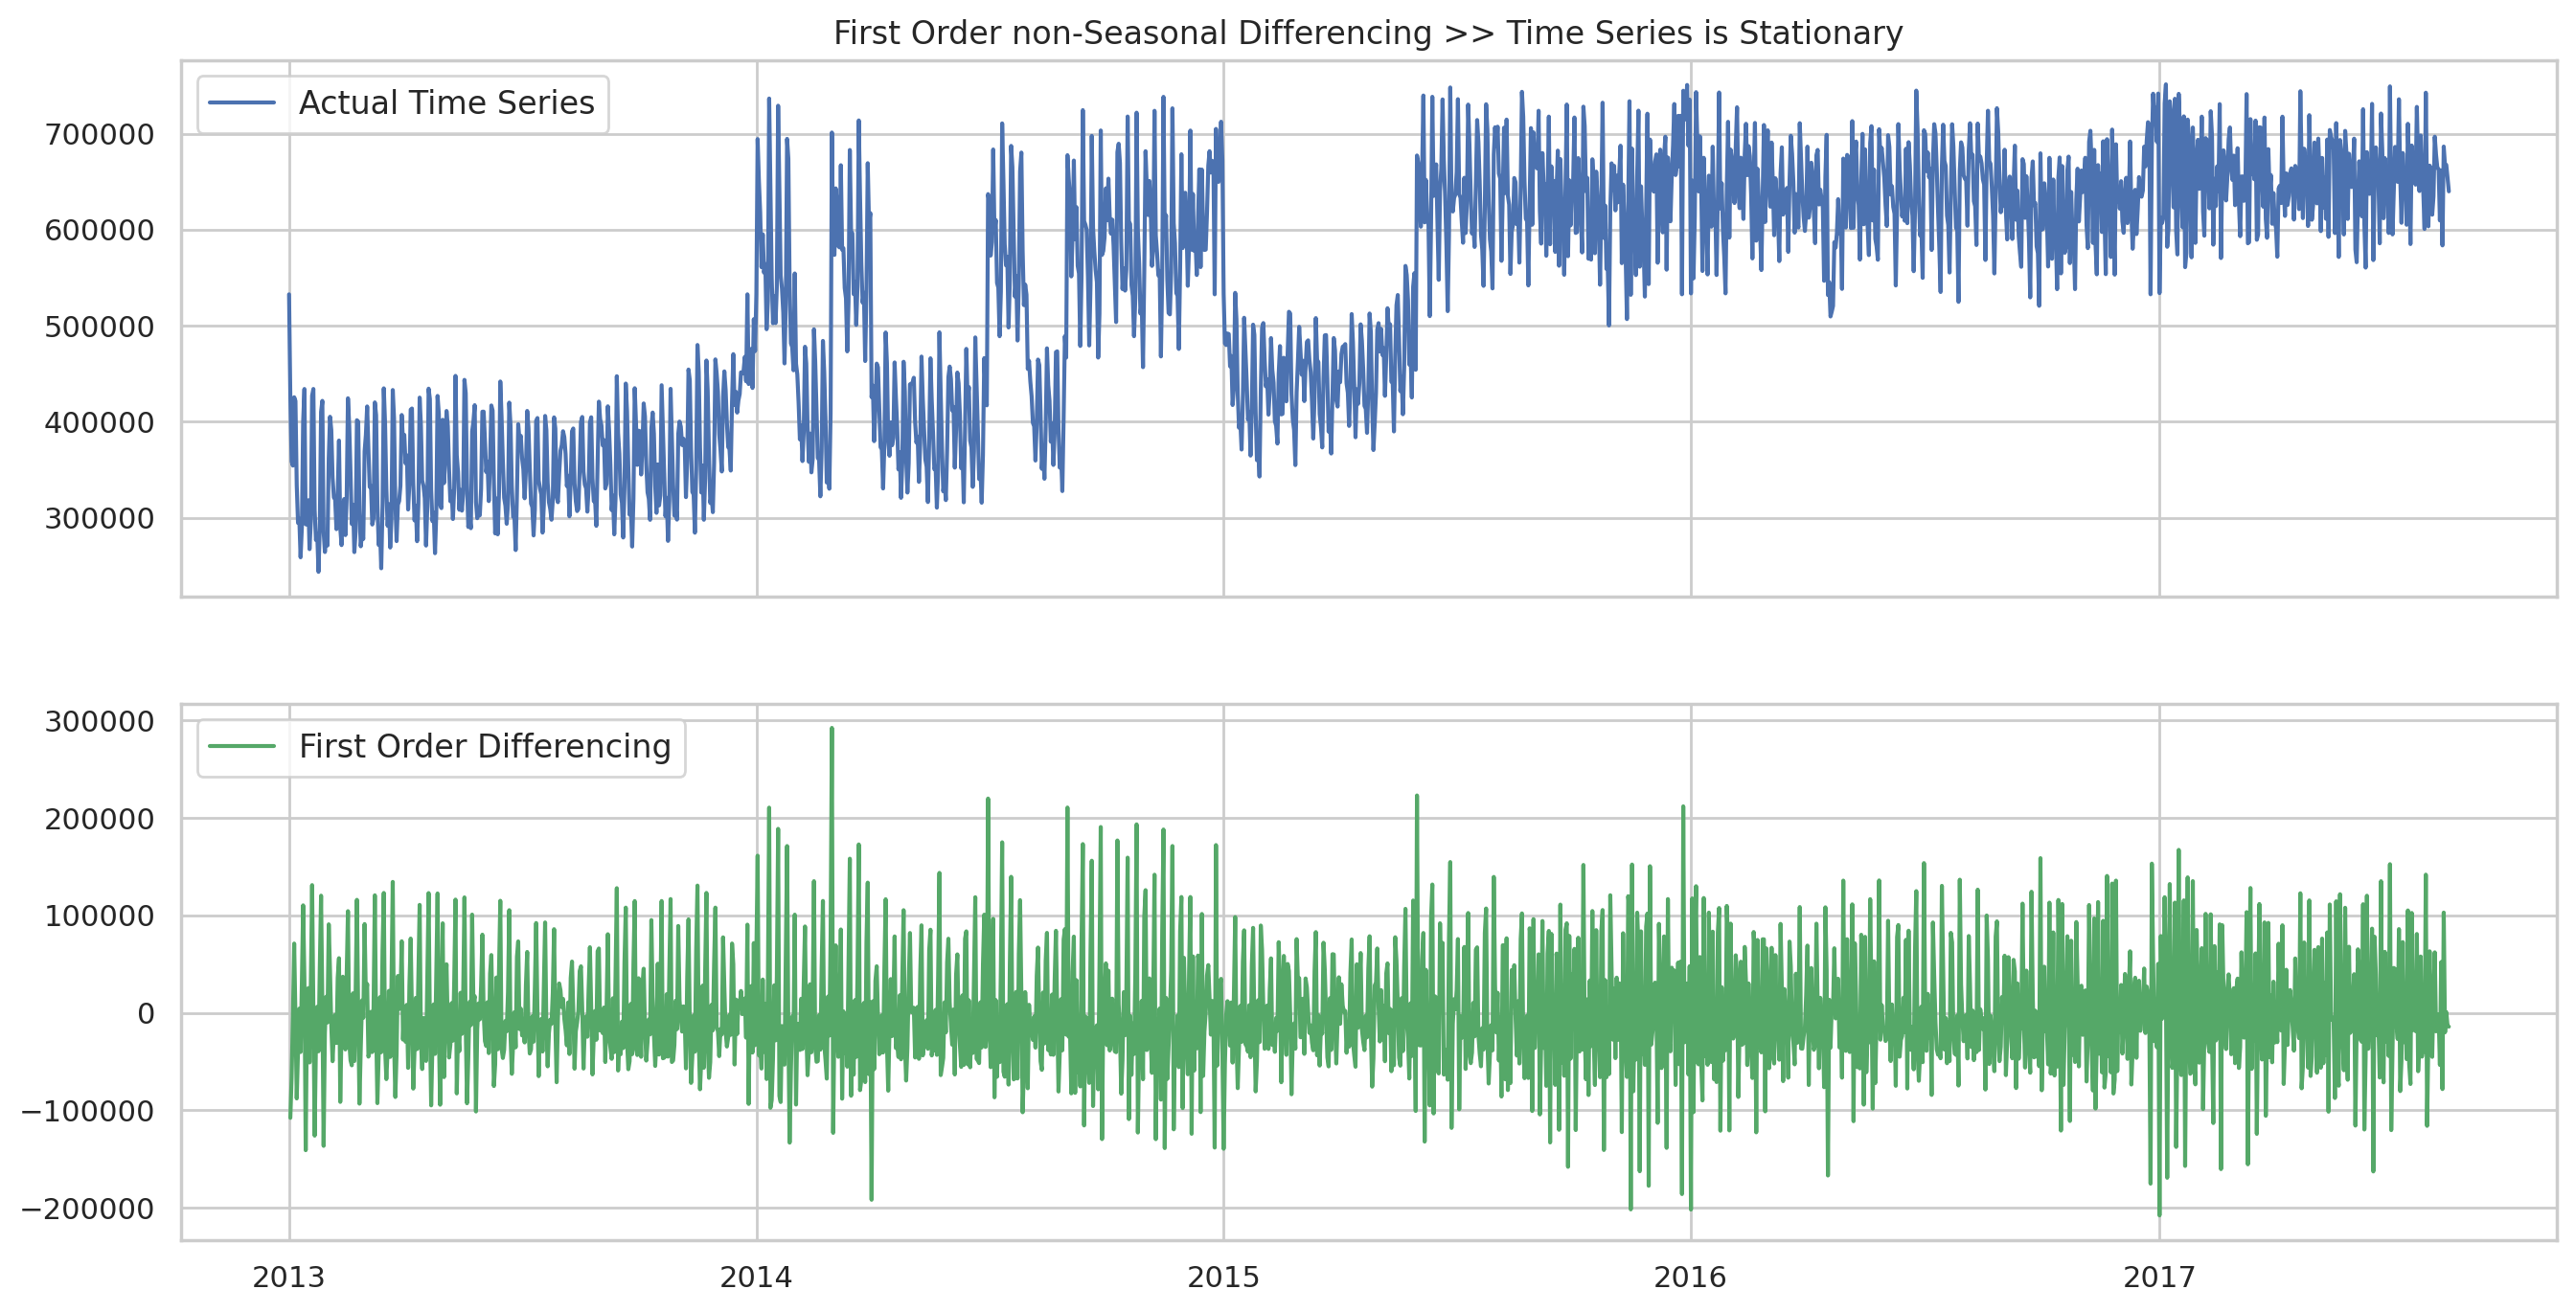

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(16,8), dpi=200, sharex=True)
# Usual Differencing
axes[0].plot(train2.sales, label='Actual Time Series')
axes[1].plot(train_diff.sales, label='First Order Differencing',color = 'g')
axes[0].set_title('First Order non-Seasonal Differencing >> Time Series is Stationary')
axes[0].legend(loc='upper left', fontsize=12)
axes[1].legend(loc='upper left', fontsize=12)

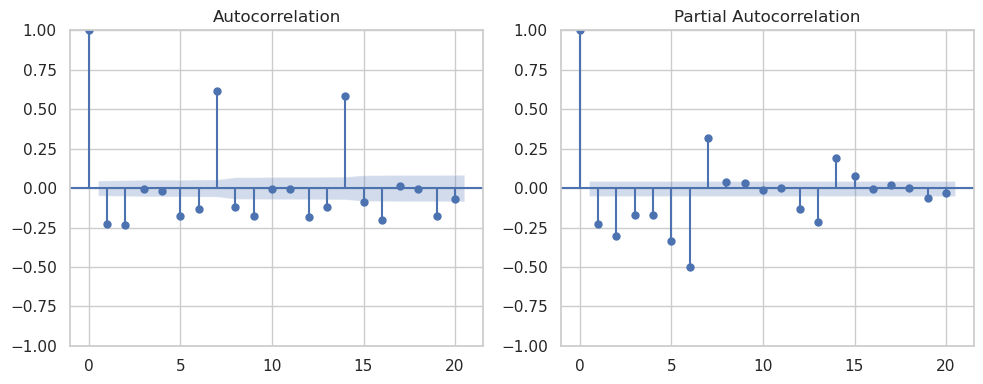

In [35]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(train_diff['sales'], ax=ax1,lags=20)
ax2 = plt.subplot(122)
plot_pacf(train_diff['sales'], ax=ax2,lags=20)
plt.tight_layout()
plt.show()

In [36]:
train_np = train_diff['sales'].values.astype('float64')

# Model selection and prediction

In [37]:
def evaluate_forecast(y_true, y_pred, model_name):
 # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
 # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
 # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
 # Print the evaluation results
    print('Model Name:', model_name)
    print('Mean Squared Error (MSE): {:.2f}'.format(mse))
    print('Root Mean Squared Error (RMSE): {:.2f}'.format(rmse))
    print('Mean Absolute Error (MAE): {:.2f}'.format(mae))
 
 # Create a DataFrame to store the evaluation results
    final_scores_df = pd.DataFrame({
 'Model Name': [model_name],
 'Mean Squared Error (MSE)': [mse],
 'Root Mean Squared Error (RMSE)': [rmse],
 'Mean Absolute Error (MAE)': [mae]
 })
    return final_scores_df

In [38]:
order_aic_bic =[]
# Loop over AR order
for p in range(10):
 # Loop over I order
      for d in range(4):
 # Loop over MA order
            for q in range(10):
 # Fit model
                model = sm.tsa.ARIMA(train_np, order=(p,d,q),enforce_stationarity=False ,enforce_invertibility=False)
                results = model.fit(method_kwargs={"warn_convergence": False})
 # print the model order and the AIC/BIC values
 # print(p, q, results.aic, results.bic)
                order_aic_bic.append((p, d, q, results.aic, results.bic))

In [39]:
order_df = pd.DataFrame(order_aic_bic, columns=['p','d','q','aic','bic'])
order_df.sort_values('aic')

p  d  q           aic           bic
369  9  0  9  40294.733557  40403.228792
329  8  0  9  40294.912872  40397.983346
289  7  0  9  40298.122326  40395.768037
249  6  0  9  40302.878368  40395.099318
328  8  0  8  40317.264698  40414.921140
..  .. .. ..           ...           ...
30   0  3  0  47356.105056  47361.533389
12   0  1  2  47454.413056  47470.698056
365  9  0  5  48110.947361  48197.753087
0    0  0  0  52928.322764  52939.182993
324  8  0  4  67673.171051  67749.134402

[400 rows x 5 columns]

In [40]:
aic_ARIMA_model = sm.tsa.ARIMA(train_np, order=(8,0,9),enforce_stationarity=False ,enforce_invertibility=False)
aic_arima_model = aic_ARIMA_model.fit(method_kwargs={"warn_convergence": False})
aic_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1687
Model:                 ARIMA(8, 0, 9)   Log Likelihood              -20128.456
Date:                Mon, 08 Apr 2024   AIC                          40294.913
Time:                        17:05:24   BIC                          40397.983
Sample:                             0   HQIC                         40333.096
                               - 1687                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.5283    387.469      0.164      0.870    -695.898     822.954
ar.L1         -0.2022      0.232     -0.872      0.383      -0.657       0.252
ar.L2         -0.4391      0.185     -2.378      0.017      -0.801      -0.077
ar.L3         -0.4382      0.185     -2.374      0.018      -0.800      -0.076
ar.L4         -0.4386      0.184     -2.382      0.017      -0.799      -0.078
ar.L5         -0.4389      0.184     -2.383      0.017      -0.800      -0.078
ar.L6         -0.4335      0.184     -2.359      0.018      -0.794      -0.073
ar.L7          0.5530      0.183      3.021      0.003       0.194       0.912
ar.L8         -0.2373      0.136     -1.751      0.080      -0.503       0.028
ma.L1         -0.2566      0.232     -1.106      0.269      -0.711       0.198
ma.L2          0.1489      0.124      1.199      0.231      -0.095       0.392
ma.L3          0.1627      0.063      2.593      0.010       0.040       0.286
ma.L4          0.1214      0.062      1.962      0.050    9.86e-05       0.243
ma.L5          0.1256      0.059      2.119      0.034       0.009       0.242
ma.L6          0.1028      0.053      1.923      0.055      -0.002       0.208
ma.L7         -0.7070      0.051    -13.866      0.000      -0.807      -0.607
ma.L8          0.3387      0.161      2.100      0.036       0.023       0.655
ma.L9         -0.0254      0.071     -0.356      0.722      -0.165       0.114
sigma2      1.721e+09      0.001   2.02e+12      0.000    1.72e+09    1.72e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2422.80
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.43
Prob(H) (two-sided):                  0.51   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.63e+26. Standard errors may be unstable.
"""

In [41]:
model = sm.tsa.ARIMA(train_np, order=(6, 1, 2))
arima_acf_pacf = model.fit()
arima_acf_pacf.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1687
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -20473.603
Date:                Mon, 08 Apr 2024   AIC                          40965.205
Time:                        17:05:33   BIC                          41014.076
Sample:                             0   HQIC                         40983.305
                               - 1687                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9041      0.037    -24.200      0.000      -0.977      -0.831
ar.L2         -0.7717      0.032    -24.137      0.000      -0.834      -0.709
ar.L3         -0.7041      0.032    -22.029      0.000      -0.767      -0.641
ar.L4         -0.6618      0.030    -22.251      0.000      -0.720      -0.603
ar.L5         -0.6523      0.028    -23.364      0.000      -0.707      -0.598
ar.L6         -0.6221      0.020    -30.557      0.000      -0.662      -0.582
ma.L1         -0.5689      0.043    -13.264      0.000      -0.653      -0.485
ma.L2         -0.4304      0.042    -10.215      0.000      -0.513      -0.348
sigma2      2.522e+09   1.27e-11   1.99e+20      0.000    2.52e+09    2.52e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):               714.59
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.40
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.8e+35. Standard errors may be unstable.
"""

In [42]:
start_idx = len(train_np)
end_idx = len(train_np) + len(test) - 1
arima_acf_pacf_forecast = arima_acf_pacf.predict(start=start_idx, end=end_idx)
aic_arima_model_forecast=aic_arima_model.predict(start=start_idx, end=end_idx)
actual=train_diff['sales']
arima_acf_pacf_forecast = arima_acf_pacf_forecast[:len(actual)]
aic_arima_model_forecast = aic_arima_model_forecast[:len(actual)]
arima_acf_pacf_model_df=evaluate_forecast(actual,arima_acf_pacf_forecast,'arima_acf_pacf')
aic_arima_model_df=evaluate_forecast(actual,aic_arima_model_forecast,'aic_arima_model')

Model Name: arima_acf_pacf
Mean Squared Error (MSE): 4046518946.29
Root Mean Squared Error (RMSE): 63612.25
Mean Absolute Error (MAE): 49684.41
Model Name: aic_arima_model
Mean Squared Error (MSE): 4864915293.43
Root Mean Squared Error (RMSE): 69748.94
Mean Absolute Error (MAE): 52482.32


In [43]:
final_scores_df = pd.concat([aic_arima_model_df, arima_acf_pacf_model_df], ignore_index=True)
final_scores_df

Model Name  Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  \
0  aic_arima_model              4.864915e+09                    69748.944748   
1   arima_acf_pacf              4.046519e+09                    63612.254686   

   Mean Absolute Error (MAE)  
0               52482.316608  
1               49684.409336

In [44]:
metric_cols = ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
for metric_col in metric_cols:
    sorted_df = final_scores_df.sort_values(metric_col)
    best_model = sorted_df.iloc[0]['Model Name']
    print('Best model for {}: {}'.format(metric_col, best_model))

Best model for Mean Squared Error (MSE): arima_acf_pacf
Best model for Root Mean Squared Error (RMSE): arima_acf_pacf
Best model for Mean Absolute Error (MAE): arima_acf_pacf


In [45]:
predictions=arima_acf_pacf.predict(start=start_idx,end=end_idx)
dic = {
    "id": test['id'].values,
    "sales": predictions
}
dic

{'id': array([3000888, 3000889, 3000890, ..., 3029397, 3029398, 3029399]),
 'sales': array([ 24143.6818701 , -52428.02978169,  60077.37455071, ...,
           117.0395739 ,    117.0395739 ,    117.0395739 ])}

In [46]:
sub = pd.DataFrame(dic)
sub.to_csv("submission.csv", index=False)